#How to Draft the Next NFL Pro Bowler

Every year, the National Football League holds a draft for players first entering the league, most of whom enter directly from playing college football. Teams are given a draft position depending on how well they fared the previous year, with the worst teams getting higher picks, and they select the rights to sign these players to contracts. Before that happens, every teams does intensive scouting on potential draft picks to determine how highly they value certain players.

One aspect of this evaluation is the NFL Scouting Combine. This occurs every year in February; players are invited to go through a variety of physical drills that are intended to measure their raw athletic ability, including speed, strength, and agility. Our goal is to evaluate whether the Scouting Combine is predictive of future success in the NFL, which drills are most predictive of success, and whether NFL teams are emphasizing the right drills when using the Scouting Combine to evaluate players.

How do we define whether a player was "successful"? There are many different ways we could do this, but for this project we have chosen to define success as whether or not a player made the NFL Pro Bowl at any point in his career. The Pro Bowl is the NFL's All-Star game; players are voted in by other players and fans based on their performance during the season.

In [72]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm


import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

##Combine Data

Our main data file contains results from the NFL Scouting Combine from 1999 through 2015. Our data file can be found at this link: http://nflsavant.com/about.php

Here is a description of the drills we plan to consider, along with their variable names in the data set.

- `fortyyd`: time in the forty-yard dash, which is an all-out sprint for 40 yards
- `bench`: number of times a player can bench press 225 pounds
- `vertical`: vertical jump, where a player stands flat-footed then jumps up as high as he can. Measured in inches.
- `broad`: broad jump, where a player stands flat-footed and then jumps forward as far as he can.
- `threecone`: time in the three cone drill; players run around three cones set in an L shape in a way that is intended to measure their ability to change direction
- `twentyss`: time in the shuttle run; the player runs 5 yards, changes direction to run 10 yards, and changes direction again to run 5 yards

We are also given data on the player's position, which will become important later for sorting, as well as height, weight, college attended, and pick with which they were eventually drafted, if they were selected (the draft is only 7 rounds, so some players go without being selected).

In [73]:
nflcomb = pd.read_csv("combine.csv")
nflcomb.head()

,year,name,firstname,lastname,position,heightfeet,heightinches,heightinchestotal,weight,arms,...,vertical,broad,bench,round,college,pick,pickround,picktotal,wonderlic,nflgrade
0,2015,Ameer Abdullah,Ameer,Abdullah,RB,5,9,69,205,0,...,42.5,130,24,0,Nebraska,NaN,0,0,0,5.9
1,2015,Nelson Agholor,Nelson,Agholor,WR,6,0,72,198,0,...,0.0,0,12,0,USC,NaN,0,0,0,5.6
2,2015,Jay Ajayi,Jay,Ajayi,RB,6,0,72,221,0,...,39.0,121,19,0,Boise St.,NaN,0,0,0,6.0
3,2015,Kwon Alexander,Kwon,Alexander,OLB,6,1,73,227,0,...,36.0,121,24,0,LSU,NaN,0,0,0,5.4
4,2015,Mario Alford,Mario,Alford,WR,5,8,68,180,0,...,34.0,121,13,0,West Virginia,NaN,0,0,0,5.3


Since we do not yet know who will make the 2016 Pro Bowl, we will exclude players who participated in the 2015 Scouting Combine.

In [74]:
nflcomb = nflcomb[nflcomb['year'] < 2015]
nflcomb.head()

,year,name,firstname,lastname,position,heightfeet,heightinches,heightinchestotal,weight,arms,...,vertical,broad,bench,round,college,pick,pickround,picktotal,wonderlic,nflgrade
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,6,1,73,195,0,...,30.5,117,4,6,Wisconsin,0,16,176,0,5.2
323,2014,Davante Adams,Davante,Adams,WR,6,1,73,212,0,...,39.5,123,14,2,Fresno St.,0,21,53,0,6.0
324,2014,Mo Alexander,Mo,Alexander,SS,6,1,73,220,0,...,38.0,123,0,4,Utah St.,0,14,110,0,4.9
325,2014,Ricardo Allen,Ricardo,Allen,CB,5,9,69,187,0,...,35.5,117,13,5,Purdue,0,19,147,0,5.1
326,2014,Jace Amaro,Jace,Amaro,TE,6,5,77,265,0,...,33.0,118,28,2,Texas Tech,0,17,49,0,5.4


In [75]:
nflcomb.columns

Index([u'year', u'name', u'firstname', u'lastname', u'position', u'heightfeet',
       u'heightinches', u'heightinchestotal', u'weight', u'arms', u'hands',
       u'fortyyd', u'twentyyd', u'tenyd', u'twentyss', u'threecone',
       u'vertical', u'broad', u'bench', u'round', u'college', u'pick',
       u'pickround', u'picktotal', u'wonderlic', u'nflgrade'],
      dtype='object')

Most of these variables are unnecessary or contain a ton of missing values, so we can drop them from our data set.

In [76]:
dropvars = ['heightfeet', 'heightinches', 'arms', 'hands', 'wonderlic', 'nflgrade', 'pick', 'twentyyd', 'tenyd']
nflcomb.drop(dropvars, axis = 1, inplace=True)
nflcomb.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,0,4,Utah St.,14,110
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,0.00,35.5,117,13,5,Purdue,19,147
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49


Missing values in this data set are coded as 0, so we need to replace those with NaNs in most cases. For now let's replace all 0 values with NaN.

In [77]:
nflcomb.replace(0, np.nan, inplace=True)
nflcomb.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,NaN,4,Utah St.,14,110
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,35.5,117,13,5,Purdue,19,147
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49


For the workout results the missing value makes sense; we don't want to assume results we don't have. However, for the draft round and pick results, a missing value actually means that the player was not drafted, not that we don't know the player's draft position. So we want our data to reflect that. For round, let's code undrafted players as being drafted in round 8, which doesn't exist. We can leave their pick within the round and pick total as missing for now.

In [78]:
nflcomb.loc[np.isnan(nflcomb.round), 'round'] = 8
nflcomb[nflcomb.round > 6].head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
327,2014,Antonio Andrews,Antonio,Andrews,RB,70,225,4.82,4.49,7.24,29.5,106,20,8,Western Kentucky,NaN,NaN
329,2014,Matt Armstrong,Matt,Armstrong,C,74,302,5.36,NaN,NaN,NaN,NaN,NaN,8,Grand Valley St.,NaN,NaN
330,2014,George Atkinson,George,Atkinson,RB,73,218,4.48,4.46,7.07,38.0,121,19,8,Notre Dame,NaN,NaN
332,2014,Dion Bailey,Dion,Bailey,SS,72,201,4.66,4.15,6.97,34.0,113,NaN,8,USC,NaN,NaN
336,2014,Deion Belue,Deion,Belue,CB,71,182,NaN,NaN,NaN,NaN,NaN,11,8,Alabama,NaN,NaN


###Position Analysis

Now that we've cleaned the data a little bit, we would like to sort it by position. The reason for this is that different players can have vastly different roles on the field, which means that a physical trait which is vitally important for one player is essentially meaningless for others. For some of our models, such sorting will be necessary.

Here is a description of each of the positions, sorted by offense and defense. For a diagram of standard offensive/defensive alignments, see here: https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Positions_American_Football.svg/2000px-Positions_American_Football.svg.png

**Offense**

- *Quarterback*: His primary job is to throw the ball to wide receivers and tight ends (see below). Arm strength and agility are the most important physical attributes for a quarterback, but success at this position depends more on mental attributes than phyiscal. Because of this uniqueness, as well as the small sample size at the positiion, we anticipate Quarterbacks to be very difficult to forecast based solely on Combine results, and we will leave them out of our grouped analysis. 

- *Running Back*: In addition to forward passes, teams can also advance the ball forward simply by carrying the ball. The running back does most of this, in addition to sometimes catching passes. Some running backs rely on speed and agility to stay away from potential tacklers, others rely on strength to power through them, and some are good at both.

- *Full Back*: Full back. Lines up in front of the running back and mainly acts as an extra blocker on run plays, in addition to occasionally running the ball himself or catching passes.

- *Wide Receiver*: Runs down the field to try to catch forward passes. Generally smaller and faster than most players, though the best receivers are also tall, in order to outjump defenders.

- *Tight End*: Essentially a hybrid between an offensive tackle and a wide receiver. They usually line up next to the offensive line and play an important role in blocking on run plays, but they can also catch passes on passing plays. Faster than OTs but slower than WRs in general, and stronger than WRs but weaker than OTs in general.

- *Offensive Tackle*: Offenses have five offensive linemen, whose job is to prevent defenders from tackling the player carrying the ball. Most of these players are around 300 pounds. Offensive tackles play the outermost position on the line. Strength is vital, because most of the players they're blocking are just as big. Agility also plays a part, especially on passing plays, because most of the players trying to tackle the quarterback, called pass rushers, are very fast in addition to strong, and tackles tend to have to take on the defense's fastest pass rushers.

- *Offensive Guard*: Offensive Guard. These offensive linemen play just inside the offensive tackles. Strength is likely to be a little more important, and agility less so, compared to offensive tackles; guards are relied on more for run blocking and blocking pass rushers who rely on strength rather than speed.

- *Center*: The middle player on the offensive line. Essentially the same as a guard, except the center also starts the play by snapping the ball to the quarterback. They are most often responsible for calling out blocking schemes depending on how the defense lines up.

**Defense**

- *Defensive End and Defensive Tackle*: They line up on the outside of the defensive line and play a big role in both defending run plays and rushing the quarterback on passing plays. Usually very large and strong, but also fast and agile. 

- *Outside Linebacker and Inside Linebacker*: Linebackers play immediately behind the defensive linemen. On running plays, they are the players expected to take down the ball-carrier. On passing plays, they sometimes will rush the quarterback and sometimes will drop back to defend passes thrown. Outside linebackers usually play a bigger role in rushing the passer than inside linebackers; inside linebackers play between the outside linebackers and usually paly a bigger role in defending the run. Their athleticism is similar to tight ends and running backs, and often they are tasked with covering these players when they go out to catch passes.

- *Cornerback*: These players play along the line of scrimmage on the outside and are responsible for covering wide receivers as they go out to catch passes. They are similar to wide receiver in athleticism, except they are usually smaller and faster than the players they're covering.

- *Free Safety and Strong Safety*: Safeties play behind the linebackers. They're the last line of defense in case a running back gets past the linebackers or a receiver gets past the cornerbacks. Strong safeties usually play a bigger role in the running game than free safeties. They're usually a bit slower and bigger than cornerbacks, and often cornerbacks will convert to safety later in their career if their speed starts to fade.

**Special Teams**

- *Kicker*: Kicks field goals, which are worth half as much as touchdowns, and performs kickoffs, which is when the team gives the ball back to the other team following a score.

- *Punter*: Teams have four downs to get a first down. If after third down they haven't gained enough yards for a first, often they will kick the ball to the other team via punt rather than risk giving the ball back if they fail to convert.

Let's look at the different position values we have in our data set.

In [7]:
nflcomb['position'].unique()

array(['WR', 'SS', 'CB', 'TE', 'RB', 'C', 'OLB', 'OT', 'OG', 'ILB', 'QB',
       'K', 'DT', 'FS', 'NT', 'P', 'DE', 'FB', 'LS', 'OC'], dtype=object)

Most of these abbreviations are straightforward: RB for Running back, etc. LS stands for long snapper, which is similar to the center but specializes in snapping the ball on punts and field goals, which requires snapping the ball a longer distance. OC and C both refer to Center. NT stands for nose tackle, which is a special type of defensive tackle who specializes almost exclusively in stopping the run.

As mentioned before, we need to break up our analysis by position. The question is how we can do that without combining positions which are too unlike each other, and while also maintaining a large enough sample size that we may still find a signal.

We also need to take into account right censorship: some players who are early in their careers haven't made the Pro Bowl yet but will make the Pro Bowl in 2016 or later. Based on that we need to exclude more recent years. We expect that most players who don't make the Pro Bowl in their first 5 years in the league are very unlikely to make it in future years; based on that we will exclude all players after 2009.

Let's create a new data frame including only players in the 2009 or earlier Combine, and let's see the sample size at each position.

In [8]:
drop09 = nflcomb[nflcomb.year <= 2009]
combpos = drop09.groupby('position')
combpos.count()

,year,name,firstname,lastname,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
position,,,,,,,,,,,,,,,,
CB,293,293,293,293,293,293,293,218,2,272,269,236,213,213,213,213
DE,262,262,262,262,262,262,262,209,8,229,228,230,184,184,184,184
DT,232,232,232,232,232,232,231,173,0,195,187,199,160,160,160,160
FB,87,87,87,87,87,87,87,70,0,81,80,78,54,54,54,54
FS,147,147,147,147,147,147,147,111,0,134,129,129,97,97,97,97
ILB,146,146,146,146,146,146,146,112,0,126,124,125,92,92,92,92
OC,100,100,100,100,100,100,99,87,0,88,88,92,56,56,56,56
OG,220,220,220,220,220,220,220,174,0,188,181,191,123,123,123,123
OLB,216,216,216,216,216,216,216,175,0,188,187,187,154,154,154,154


From these numbers a few groupings make obvious sense, because they produce a large sample size and combine positions requiring similar skills:
    
1. Lump CB, FS and SS together into the "defensive back" category
2. Lump OT, OG and OC together into the "offensive line" category
3. Lump OLB and ILB together into the "linebacker" category
4. Lump DT and DE together into the "defensive line" category

The rest of the positions could be lumped together in any number of ways. We will exclude K, P, and QB due to small sample size and lack of obvious grouping options.

To aid in these decisions I first glanced at the averages at the positions in both physical attributes and performance in certain drills.

In [9]:
combpos.mean()

,year,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,pickround,picktotal
position,,,,,,,,,,,,
CB,2004.122867,71.259386,192.034130,4.490751,4.156927,6.710000,36.303309,121.133829,14.495763,3.539906,17.042254,101.154930
DE,2003.877863,75.835878,268.125954,4.845076,4.411866,7.306250,33.054585,113.583333,23.665217,3.798913,18.456522,112.250000
DT,2003.793103,75.172414,304.189655,5.103377,4.614682,NaN,29.497436,105.117647,26.984925,3.893750,17.300000,113.918750
FB,2003.517241,72.839080,244.505747,4.751954,4.373000,NaN,32.759259,112.825000,22.705128,5.055556,21.148148,157.314815
FS,2004.040816,72.918367,204.231293,4.566531,4.201802,NaN,36.089552,120.279070,16.310078,4.216495,19.051546,126.340206
ILB,2003.712329,73.664384,242.082192,4.763904,4.307143,NaN,33.134921,113.467742,22.416000,3.793478,18.956522,111.532609
OC,2003.920000,75.410000,301.720000,5.235859,4.623333,NaN,28.801136,101.602273,25.923913,4.089286,20.339286,123.589286
OG,2003.259091,76.131818,314.045455,5.325182,4.771437,NaN,27.875000,99.801105,25.214660,4.504065,18.934959,136.300813
OLB,2004.134259,74.055556,238.060185,4.681528,4.261829,NaN,34.558511,116.609626,22.074866,3.850649,18.051948,112.922078


Here are the choices we made:

- Add tight ends and fullbacks to the linebacker category. These positions are very different in role, but the athletic skills needed of athletes at both positions are very similar, and their averages in terms of weight, forty yard dash time, and bench press time are similar. This isn't idea from an analysis perspective, because we'd like to keep them separate, but the small sample size in TE/FB means that we can't analyze them on their own, and their athletic makeup makes them poor fits to be combined with other offensive positions.
- Combine running backs and wide receivers into one category. We came in expecting these positions to be too different to justify combining, but they're actually pretty similar in terms of physical attributes and performance in the drills, and the sample size in the running back group isn't large enough to make it okay to leave them on their own.

At this point we are left with 5 different groups. Since we plan to fit separate models to each of these groups, we would like to reduce this further. To do so, we make the following choices.

- Combine offensive linemen and defensive linemen into a general linemen category
- Combine defensive backs with running backs and wide receivers to create a "backs and receivers" category

In general, we are compromising the ability to do our analysis on a position-specific level by doing this. In most cases, such ability was already compromised by a small sample size. In cases where it wasn't, we chose to limit the number of groups so that we didn't have to fit too many different models. Using interaction terms for all positions would be even more unwieldy considering the number of different positions and the number of variables we're including. We will attempt to be more focused in our position analysis using our ungrouped data, but for the grouped case, our focus is to reduce the number of models we need to fit and make sure our sample size is large enough to find a signal.

We will do these combinations once we take care of adding the Pro Bowl data. For now we will create lists of positions in each group for later reference. Backs refers to the backs/receivers group, Line refers to the linemen, and Hybrid refers to the linebackers/tight ends group. 

In [10]:
backs = ['CB', 'FS', 'SS', 'RB', 'WR']
line = ['DT', 'DE', 'NT', 'OT', 'OG', 'OC', 'C', 'LS'] 
# Peeking at later data reveals that OC is sometimes coded as LS or C
hyb = ['OLB', 'ILB', 'MLB', 'TE', 'FB'] # Stands for hybrid; ILB is sometimes coded as MLB in future data

##Pro Bowl Data

The Combine data set didn't include any Pro Bowl data, so we need to scrape that for ourselves. Pro Football Reference has the roster from every year available in a nice CSV format, so we simply needed to download all the files and then import them as their own data frames.

Note that these data indicate the year in which these players were named to the Pro Bowl, but the game to which the players were named was played in the next year. For example, a player named to the Pro Bowl in 1999 in the data would play in the 2000 Pro Bowl. We will correct this later.

In [11]:
years = range(1999, 2015, 1)
filenames = {year:"years_" + str(year) + "_probowl_pro_bowl.csv" for year in years}
filenames

{1999: 'years_1999_probowl_pro_bowl.csv',
 2000: 'years_2000_probowl_pro_bowl.csv',
 2001: 'years_2001_probowl_pro_bowl.csv',
 2002: 'years_2002_probowl_pro_bowl.csv',
 2003: 'years_2003_probowl_pro_bowl.csv',
 2004: 'years_2004_probowl_pro_bowl.csv',
 2005: 'years_2005_probowl_pro_bowl.csv',
 2006: 'years_2006_probowl_pro_bowl.csv',
 2007: 'years_2007_probowl_pro_bowl.csv',
 2008: 'years_2008_probowl_pro_bowl.csv',
 2009: 'years_2009_probowl_pro_bowl.csv',
 2010: 'years_2010_probowl_pro_bowl.csv',
 2011: 'years_2011_probowl_pro_bowl.csv',
 2012: 'years_2012_probowl_pro_bowl.csv',
 2013: 'years_2013_probowl_pro_bowl.csv',
 2014: 'years_2014_probowl_pro_bowl.csv'}

Now we want to save each of these csvs as a DataFrame in a dictionary keyed by its year.

In [12]:
filedict = {}
for year in years:
    roster = pd.read_csv(filenames[year])
    roster = roster[np.isfinite(roster['Age'])] # Drops some erroneously generated rows with no players and lots of NaNs
    filedict[year] = roster[['Pos', 'Unnamed: 1', 'Conf', 'Tm']] # Drops all unneeded rows
filedict[1999].head()

,Pos,Unnamed: 1,Conf,Tm
0,WR,Marvin Harrison+%,AFC,IND
4,RB,Edgerrin James+%,AFC,IND
8,LG,Larry Allen+%,NFC,DAL
12,LT,Tony Boselli+%,AFC,JAX
16,RLB,Kevin Hardy+%,AFC,JAX


###Cleaning the Pro Bowl Files

In [13]:
filedict[1999]["Unnamed: 1"].values

array(['Marvin Harrison+%', 'Edgerrin James+%', 'Larry Allen+%',
       'Tony Boselli+%', 'Kevin Hardy+%', 'Tony Gonzalez+%',
       'Sam Madison+%', 'Olindo Mare+%', 'Jevon Kearse+%',
       'Kevin Carter+%', 'Marshall Faulk+%', 'Orlando Pace+%',
       'Kurt Warner+%', 'Ray Lewis+%', 'Derrick Brooks+%', 'John Lynch+%',
       'Warren Sapp+%', 'Mitch Berger+%', 'Darrell Russell+%',
       'Glyn Milburn+%', 'Cris Carter+%', 'Lawyer Milloy+%',
       'Kevin Mawae+%', 'Bruce Matthews+%', 'Charles Woodson+%',
       'Deion Sanders+%', 'Carnell Lake+%', 'Isaac Bruce+%',
       'Michael Bates+%', 'Trevor Pryce+%', 'Jeff Christy+%', 'Tom Tupa+%',
       'Tom Nalen+%', 'Will Shields+%', 'Zach Thomas+%', 'Mike Alstott+%',
       'Ruben Brown+%', 'Wesley Walls+%', 'Peyton Manning+%',
       'Tony Brackens+%', 'Jimmy Smith+%', 'Jessie Armstead+%',
       'Eddie George+%', 'Todd Lyght+%', 'Peter Boulware+%',
       'Jonathan Ogden+%', 'Hardy Nickerson+%', 'Stephen Davis+%',
       "Tre' Johnson+%

We will focus on modifying the player names and building a dictionary of Pro Bowl Rosters. However, we may need to refer back to the original data frames if we find players with the same name in our Combine file; more on that later.

The % symbol after players' names is supposed to indicate that they didn't play in the game, but it seems that every player has a % symbol, so this is likely inaccurate; we will drop it.

The + symbol is potentially of interest; it indicates that a player played in the game as an injury replacement. This means that the player wasn't selected to the Pro Bowl in initial voting, but they were just outside of being selected and played because one of the selected players got hurt. Ideally we would prefer to exclude these players; such inclusion is based on a selected player getting injured, which is pretty random year to year.

Examining the data, it seems that the + symbol is only used to indicate the player actually didn't play starting in 2009. So starting with 2009, we will exclude players with a + symbol; for years before that we will include all players.

In [14]:
rosterdict = {}
for year in years:
    roster = [x for x in filedict[year]["Unnamed: 1"].values if str(x) != 'nan']
    if year < 2009:
        rosterfinal = [x[:-2] for x in roster] # Removes the %+ substring for every player
    else:
        rosterfinal = [x[:-1] for x in roster if "+" not in x]
    rosterdict[year] = rosterfinal

In [15]:
print rosterdict[1999][:5], rosterdict[2011][:5]

['Marvin Harrison', 'Edgerrin James', 'Larry Allen', 'Tony Boselli', 'Kevin Hardy'] ['Aaron Rodgers', 'Drew Brees', 'Tom Brady', 'Eli Manning', 'Ben Roethlisberger']


It looks like the player names are in the format we want, with no symbols and the complete name included. Let's see the number of Pro Bowlers from each year.

In [16]:
for year in years:
    print year, len(rosterdict[year])

1999 91
2000 97
2001 106
2002 99
2003 100
2004 101
2005 98
2006 102
2007 103
2008 98
2009 85
2010 86
2011 84
2012 86
2013 88
2014 89


This is problematic; it looks like the data files before 2009 included players who played as injury replacements but didn't correctly designate them as such; notice the larger roster sizes in those years. 

Since the number of injury replacements each year seems consistent enough, and the players named as replacements are still very good, since they just missed out on being voted in, we will include injury replacement players in all years. This means we need to redo our code from before to rebuild the dictionaries.

In [17]:
rosterdict = {}
for year in years:
    roster = [x for x in filedict[year]["Unnamed: 1"].values if str(x) != 'nan']
    if year < 2009:
        rosterfinal = [x[:-2] for x in roster] # Removes the %+ substring for every player
    else:
        rosterfinal = [x.replace("+", "").replace("%", "") for x in roster]
    rosterdict[year] = rosterfinal

In [18]:
for year in years:
    print year, len(rosterdict[year])

1999 91
2000 97
2001 106
2002 99
2003 100
2004 101
2005 98
2006 102
2007 103
2008 98
2009 121
2010 116
2011 109
2012 118
2013 116
2014 115


This looks problematic for a different reason: there seem to be a lot more injury replacements in 2009 and beyond. This can be explained by a logistical change made to the Pro Bowl starting in 2009: the Pro Bowl, which used to be played the week after the Super Bowl, was moved to the week before. This means that any player on a Super Bowl team would be replaced even if they weren't injured, and it likely means that more players who are injured during the playoffs will decide not to play.

This could cause bias in our analysis; many players who are declared Pro Bowlers in 2009 or beyond likely would not have been declared Pro Bowlers in 2008 or earlier due to this change. We don't have a clear way to address this other than to acknowledge it as a potential weakness and hope it doesn't severely skew our analysis later on.

#Combining the Pro Bowl and Combine data sets

Now we want to pull these two sources together into one. First, let's check our Combine data for players who have the same name.

In [19]:
dups = nflcomb[nflcomb.name.duplicated()]
dups.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
1222,2012,Phillip Thomas,Phillip,Thomas,FS,71,198,4.74,NaN,NaN,33.0,122,14,NaN,NaN,NaN,NaN
1385,2011,Andrew Jackson,Andrew,Jackson,OG,77,299,5.27,4.65,NaN,28.0,98,25,7,Fresno State,7,210
1548,2011,Nate Williams,Nate,Williams,SS,73,211,4.68,4.15,NaN,30.5,114,17,NaN,NaN,NaN,NaN
1588,2010,Charles Brown,Charles,Brown,OT,78,303,5.24,NaN,NaN,31.5,NaN,21,2,USC,32,64
1915,2009,Will Davis,Will,Davis,DE,74,261,4.84,4.45,NaN,33.0,115,27,6,Illinois,31,204


Looks like we have some players with the same name. Let's look at a couple of different cases.

In [20]:
nflcomb[nflcomb['name'] == 'Phillip Thomas']

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
898,2013,Phillip Thomas,Phillip,Thomas,FS,72,208,4.65,NaN,NaN,35,122,14,4,Fresno State,22,119
1222,2012,Phillip Thomas,Phillip,Thomas,FS,71,198,4.74,NaN,NaN,33,122,14,NaN,NaN,NaN,NaN


It looks like Phillip Thomas went to the Combine in 2012, wasn't drafted, then went again the year after and was drafted. We would want to drop his 2012 instance.

In [21]:
nflcomb = nflcomb[(nflcomb['name'] != "Phillip Thomas") | (nflcomb['year'] == 2013)]
nflcomb[nflcomb['name'] == 'Phillip Thomas']

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
898,2013,Phillip Thomas,Phillip,Thomas,FS,72,208,4.65,NaN,NaN,35,122,14,4,Fresno State,22,119


In [22]:
nflcomb[nflcomb['name'] == 'Andrew Jackson']

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
463,2014,Andrew Jackson,Andrew,Jackson,ILB,73,254,NaN,NaN,NaN,NaN,NaN,NaN,7,Western Kentucky,11,203
1385,2011,Andrew Jackson,Andrew,Jackson,OG,77,299,5.27,4.65,NaN,28,98,25,7,Fresno State,7,210


Andrew Jackson's case is what we expect in almost all other duplicate cases: two different players who happen to have the same first and last name.

It will be too time-consuming to check every case, so let's focus on the cases that are most important: players with duplicated names who went to the Pro Bowl. Let's save their names in a dictionary indicating which years they made the Pro Bowl.

In [23]:
produps = []
namedict = {}
for name in dups.name.values:
    for year in years:
        roster = rosterdict[year]
        if name in roster:
            if name not in namedict.keys():
                namedict[name] = []
            if name not in produps:
                produps.append(name)
            namedict[name].append(year)
            
namedict

{'Adrian Peterson': [2007, 2008, 2009, 2010, 2012, 2013],
 'Alex Smith': [2013],
 'Brandon Marshall': [2008, 2009, 2011, 2012, 2013],
 'Brandon Moore': [2011],
 'C.J. Mosley': [2014],
 'Derrick Johnson': [2011, 2012, 2013],
 'Jared Allen': [2007, 2008, 2009, 2011, 2012],
 'Marcus Washington': [2004],
 'Michael Bennett': [2002],
 'Ricky Williams': [2002],
 'Steve Smith': [2001,
  2005,
  2006,
  2008,
  2009,
  2011,
  2001,
  2005,
  2006,
  2008,
  2009,
  2011]}

This is a more manageable list of names to investigate individually. Let's do that.

In [24]:
nflcomb[nflcomb.name.isin(produps)].sort('name')

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
3974,2002,Adrian Peterson,Adrian,Peterson,RB,70,214,4.68,4.60,NaN,34.0,119,14,6,Georgia Southern,27,199
2585,2007,Adrian Peterson,Adrian,Peterson,RB,74,217,4.40,4.40,NaN,38.5,127,NaN,1,Oklahoma,7,7
3201,2005,Alex Smith,Alex,Smith,TE,76,258,4.75,NaN,NaN,NaN,NaN,28,3,Utah,1,1
3200,2005,Alex Smith,Alex,Smith,QB,76,217,4.71,3.97,NaN,32.0,113,NaN,1,Utah,1,1
1121,2012,Brandon Marshall,Brandon,Marshall,OLB,73,242,4.81,4.09,7.05,30.0,108,28,5,Nevada,7,142
2822,2006,Brandon Marshall,Brandon,Marshall,WR,77,229,4.52,4.31,6.96,37.0,120,NaN,4,UCF,22,119
3958,2002,Brandon Moore,Brandon,Moore,OLB,73,239,4.61,NaN,NaN,36.5,113,23,NaN,NaN,NaN,NaN
3957,2002,Brandon Moore,Brandon,Moore,DT,75,293,5.26,4.64,NaN,25.5,96,32,NaN,NaN,NaN,NaN
3147,2005,C.J. Mosley,C.J.,Mosley,DT,74,312,5.08,4.65,NaN,27.5,100,27,6,Missouri,17,191
540,2014,C.J. Mosley,C.J.,Mosley,ILB,74,234,NaN,4.40,7.30,35.0,118,NaN,1,Alabama,17,17


This answers the first pressing question: why did the Steve Smith years become duplicated? The answer is that three different Steve Smiths went to the scouting combine. We can also see that Derrick Johnson is a duplicate from the same year, coded once accidentally as a CB as well as an OLB. We will drop this.

In [25]:
nflcomb = nflcomb[(nflcomb['name'] != "Derrick Johnson") | (nflcomb['position'] == "OLB")]
nflcomb[nflcomb.name == "Derrick Johnson"]

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal
3103,2005,Derrick Johnson,Derrick,Johnson,OLB,75,242,4.52,3.93,NaN,37.5,120,NaN,1,Texas,15,15


What about the remaining 10 names? Investigation (and prior knowledge) reveals the following:

- Adrian Peterson: all appearances made by 2007 Adrian Peterson
- Alex Smith: only appearance made by QB Alex Smith
- Brandon Marshall: all appearances made by 2006 Brandon Marshall
- Brandon Moore: only appearance made by DT Brandon Moore. Investigation here also revealed that Moore changed his position to OG and made the Pro Bowl at that position.
- C.J. Mosley: only appearance made by 2014 C.J. Mosley
- Jared Allen: all appearances made by 2004 Jared Allen
- Marcus Washington: only appearance made by 2000 Marcus Washington
- Michael Bennett: only appearance made by 2002 Michael Bennett
- Ricky Williams: only appearance made by 1999 Ricky Williams
- Steve Smith: 2009 appearance made by 2007 Steve Smith, all other appearances made by 2001 Steve Smith

Using these results, we will start to combine the Pro Bowl results with the Scouting Combine results. We will create a copy of `nflcomb` and add two variables: number of Pro Bowls and year of first Pro Bowl.

In [26]:
alldata = nflcomb.copy()
alldata['probowls'] = np.nan
alldata['firstprobowl'] = np.nan
alldata.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176,NaN,NaN
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53,NaN,NaN
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,NaN,4,Utah St.,14,110,NaN,NaN
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,35.5,117,13,5,Purdue,19,147,NaN,NaN
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49,NaN,NaN


Now we will handle all our special cases by brute force.

In [27]:
# Adrian Peterson
alldata['probowls'][3974] = 0
alldata['probowls'][2585] = 6
alldata['firstprobowl'] = 2007
# Alex Smith
alldata['probowls'][3201] = 0
alldata['probowls'][3200] = 1
alldata['firstprobowl'][3200] = 2013
# Brandon Marshall
alldata['probowls'][1121] = 0
alldata['probowls'][2822] = 5
alldata['firstprobowl'][2822] = 2008
# Brandon Moore
alldata['probowls'][3958]
alldata['probowls'][3957] = 1
alldata['firstprobowl'][3957] = 2011
alldata['position'][3957] = 'OG' # Change position
# C.J. Mosley
alldata['probowls'][3147] = 0
alldata['probowls'][540] = 1
alldata['firstprobowl'][540] = 2014
# Jared Allen
alldata['probowls'][2960] = 0
alldata['probowls'][3246] = 5
alldata['firstprobowl'][3246] = 2007
# Marcus Washington
alldata['probowls'][4916] = 0
alldata['probowls'][4553] = 1
alldata['firstprobowl'][4553] = 2004
# Michael Bennett
alldata['probowls'][1864] = 0
alldata['probowls'][4064] = 1
alldata['firstprobowl'][4064] = 2002
# Ricky Williams
alldata['probowls'][4037] = 0
alldata['probowls'][4932] = 1
alldata['firstprobowl'][4932] = 2004
# Steve Smith
alldata['probowls'][4003] = 0
alldata['probowls'][2623] = 1
alldata['firstprobowl'][2623] = 2009
alldata['probowls'][4258] = 1
alldata['firstprobowl'][4258] = 2001

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py

In [28]:
alldata[np.isfinite(alldata['probowls'])]

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl
540,2014,C.J. Mosley,C.J.,Mosley,ILB,74,234,NaN,4.40,7.30,35.0,118,NaN,1,Alabama,17,17,1,2014
1121,2012,Brandon Marshall,Brandon,Marshall,OLB,73,242,4.81,4.09,7.05,30.0,108,28,5,Nevada,7,142,0,2007
1864,2009,Michael Bennett,Michael,Bennett,DE,76,274,5.00,NaN,NaN,31.0,110,24,NaN,NaN,NaN,NaN,0,2007
2585,2007,Adrian Peterson,Adrian,Peterson,RB,74,217,4.40,4.40,NaN,38.5,127,NaN,1,Oklahoma,7,7,6,2007
2623,2007,Steve Smith,Steve,Smith,WR,73,197,4.44,4.19,6.68,38.0,120,NaN,2,USC,19,51,1,2009
2822,2006,Brandon Marshall,Brandon,Marshall,WR,77,229,4.52,4.31,6.96,37.0,120,NaN,4,UCF,22,119,5,2008
2960,2005,Jared Allen,Jared,Allen,QB,74,218,4.93,4.39,NaN,27.5,106,NaN,NaN,NaN,NaN,NaN,0,2007
3147,2005,C.J. Mosley,C.J.,Mosley,DT,74,312,5.08,4.65,NaN,27.5,100,27,6,Missouri,17,191,0,2007
3200,2005,Alex Smith,Alex,Smith,QB,76,217,4.71,3.97,NaN,32.0,113,NaN,1,Utah,1,1,1,2013
3201,2005,Alex Smith,Alex,Smith,TE,76,258,4.75,NaN,NaN,NaN,NaN,28,3,Utah,1,1,0,2007


We have handled all our Pro Bowl duplicates, which means that while there might be other duplicates in our Combine results data, they didn't make the Pro Bowl. We can then proceed to code the Pro Bowl results for the rest of our Pro Bowl players.

For each player, we start from the year the player entered the league. We tried doing this for all years at first, but we realized that two of our Combine entries mistakenly got credit for multiple Pro Bowl appearances. These players had the same name as players who had entered the league before 1999, which is why they didn't show up as duplicates above.

In [29]:
for i in alldata.index:
    if np.isnan(alldata['probowls'][i]): # To avoid messing with duplicates
        
        entryyear = alldata['year'][i] 
        alldata['probowls'][i] = 0
        nofirst = True
        for year in xrange(entryyear, 2015, 1):
            if alldata['name'][i] in rosterdict[year]:
                
                alldata['probowls'][i] += 1 # Increment number of Pro Bowls
                
                if nofirst:
                    alldata['firstprobowl'][i] = year # Store year of first Pro Bowl made
                    nofirst = False

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
alldata.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176,0,2007
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53,0,2007
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,NaN,4,Utah St.,14,110,0,2007
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,35.5,117,13,5,Purdue,19,147,0,2007
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49,0,2007


We intended to leave first year as NaN in the case of making no Pro Bowls, but for some reason our code seems to be generating 2007 as first Pro Bowl made for all players who didn't made a Pro Bowl. Let's check players who did make a Pro Bowl to see if that went as expected.

In [31]:
alldata[alldata['probowls'] > 0].tail()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl
4917,1999,Brian Waters,Brian,Waters,TE,74,281,5.00,4.63,NaN,32.0,114,26,NaN,NaN,NaN,NaN,6,2004
4932,1999,Ricky Williams,Ricky,Williams,RB,71,244,4.56,NaN,NaN,37.0,124,NaN,1,Texas,5,5,1,2004
4933,1999,Al Wilson,Al,Wilson,ILB,73,239,4.56,4.25,NaN,33.0,116,17,1,Tennessee,31,31,5,2001
4935,1999,Antoine Winfield,Antoine,Winfield,CB,69,176,4.41,3.95,NaN,37.0,122,NaN,1,Ohio State,23,23,3,2008
4939,1999,Damien Woody,Damien,Woody,OC,75,328,5.14,4.99,NaN,28.5,100,26,1,Boston College,17,17,1,2002


Looks okay. Let's just go back and recode NaN for any players who made 0 Pro Bowls.

In [32]:
for i in alldata.index:
    if alldata['probowls'][i] == 0:
        alldata['firstprobowl'][i] = np.nan
        
alldata.head()

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176,0,NaN
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53,0,NaN
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,NaN,4,Utah St.,14,110,0,NaN
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,35.5,117,13,5,Purdue,19,147,0,NaN
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49,0,NaN


That seems to have fixed the issue.

We now want to look at when in their careers players make their first Pro Bowl. We can get this by taking the year they played in their first Pro Bowl, `firstprobowl + 1`, and subtracting the year they entered the league, which would be `year`, the year they participated in the Combine.

In [33]:
alldata['yearstofirst'] = np.nan
for i in alldata.index:
    if ~np.isnan(alldata['firstprobowl'][i]):
        alldata['yearstofirst'][i] = alldata['firstprobowl'][i] - alldata['year'][i] + 1
        
alldata[alldata['probowls'] > 0].head()

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst
335,2014,Odell Beckham,Odell,Beckham,WR,71,198,4.43,3.94,6.69,38.5,122,7,1,LSU,12,12,1,2014,1
394,2014,Aaron Donald,Aaron,Donald,DT,73,285,4.68,NaN,7.11,32.0,116,35,1,Pittsburgh,13,13,1,2014,1
519,2014,Zack Martin,Zack,Martin,OT,76,308,NaN,4.59,7.65,28.0,106,29,1,Notre Dame,16,16,1,2014,1
540,2014,C.J. Mosley,C.J.,Mosley,ILB,74,234,NaN,4.40,7.30,35.0,118,NaN,1,Alabama,17,17,1,2014,1
662,2013,C.J. Anderson,C.J.,Anderson,RB,68,224,4.60,4.12,7.15,32.0,119,17,NaN,NaN,NaN,NaN,1,2014,2


Looks like it's being coded correctly for the players who made a Pro Bowl. Let's make sure that's also the case for players who didn't.

In [34]:
alldata.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,vertical,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,30.5,117,4,6,Wisconsin,16,176,0,NaN,NaN
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,39.5,123,14,2,Fresno St.,21,53,0,NaN,NaN
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,38.0,123,NaN,4,Utah St.,14,110,0,NaN,NaN
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,35.5,117,13,5,Purdue,19,147,0,NaN,NaN
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,33.0,118,28,2,Texas Tech,17,49,0,NaN,NaN


Looks good so far.

Before we proceed, we also need to create the variable we are actually trying to predict: whether the player made a Pro Bowl or not.

In [41]:
alldata['probowl_i'] = [int(x) for x in alldata['probowls'] > 0]
alldata.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,...,broad,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i
322,2014,Jared Abbrederis,Jared,Abbrederis,WR,73,195,4.50,4.08,6.80,...,117,4,6,Wisconsin,16,176,0,NaN,NaN,0
323,2014,Davante Adams,Davante,Adams,WR,73,212,4.56,4.30,6.82,...,123,14,2,Fresno St.,21,53,0,NaN,NaN,0
324,2014,Mo Alexander,Mo,Alexander,SS,73,220,4.54,4.51,7.05,...,123,NaN,4,Utah St.,14,110,0,NaN,NaN,0
325,2014,Ricardo Allen,Ricardo,Allen,CB,69,187,4.61,4.15,NaN,...,117,13,5,Purdue,19,147,0,NaN,NaN,0
326,2014,Jace Amaro,Jace,Amaro,TE,77,265,4.74,4.30,7.42,...,118,28,2,Texas Tech,17,49,0,NaN,NaN,0


We also may want to fit models which can predict which players NFL teams will use high draft picks on. To get a good sense of this, we will want to pick a measure that covers a proportion of players similar to the proportion of players who make the Pro Bowl.

In [43]:
np.mean(alldata.probowl_i == 1)

0.06986805104910232

So we want a measure that captures roughly the top 7 percent of players at the Combine. Let's see if selecting all first round picks will do the trick.

In [83]:
np.mean(alldata.round == 1)

0.092580575383949815

About 9 percent of players are first round picks. This isn't quite the same, so let's see if we can do a little better. `pickround` tells us which pick in the round the player was taken with. There are 32 picks in the first round, so let's shave off a few picks at the end of the first round to see where that gets us.

In [86]:
np.mean((alldata.round == 1) & (alldata.pickround <= 25))

0.071598529093662128

That looks like a good standard. Let's create the indicator variable we will predict here, call it `highpick_i`.

In [88]:
alldata['highpick_i'] = 0
alldata.loc[(alldata.round == 1) & (alldata.pickround <= 25), 'highpick_i'] = 1
alldata[alldata.round == 1].head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,...,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i,highpick_i
333,2014,Anthony Barr,Anthony,Barr,OLB,77,255,4.66,4.19,6.82,...,15,1,UCLA,9,9,0,NaN,NaN,0,1
335,2014,Odell Beckham,Odell,Beckham,WR,71,198,4.43,3.94,6.69,...,7,1,LSU,12,12,1,2014,1,1,1
337,2014,Kelvin Benjamin,Kelvin,Benjamin,WR,77,240,4.61,4.39,7.33,...,13,1,Florida St.,28,28,0,NaN,NaN,0,0
347,2014,Blake Bortles,Blake,Bortles,QB,77,232,4.93,4.21,7.08,...,NaN,1,Central Florida,3,3,0,NaN,NaN,0,1
354,2014,Teddy Bridgewater,Teddy,Bridgewater,QB,74,214,NaN,4.20,7.17,...,NaN,1,Louisville,32,32,0,NaN,NaN,0,0


Looks like it did what we wanted. To avoid having to continuously run the above code every time we work on the project, we will save this in alldata.csv.

In [ ]:
alldata.to_csv("alldata.csv")

Now if we want to load the data again, we can just run this one-liner.

In [ ]:
alldata = pd.read_csv("alldata.csv")

##Creating our Analysis Data Frames

Now that the data is in a nice format for us to analyze, we want to create data frames that we can actually use for analysis. There are x issues we still need to address:

1. Narrow down to the years we want to analyze
2. Break down into grouped and ungrouped cases
3. Handle missing values in the grouped case

###Narrow down years

We need to make sure we don't include too many players who are early enough in their career that they still have a very good chance of making the Pro Bowl. At the same time, we don't want to restrict our data so much that our sample size prevents us from finding a signal. To get an idea of how many years we should leave out, let's take a look at how long it typically takes an NFL player to make his first Pro Bowl.

(array([ 46.,  65.,  61.,  43.,  37.,  26.,  20.,  14.,   5.,   6.]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.]),
 <a list of 10 Patch objects>)

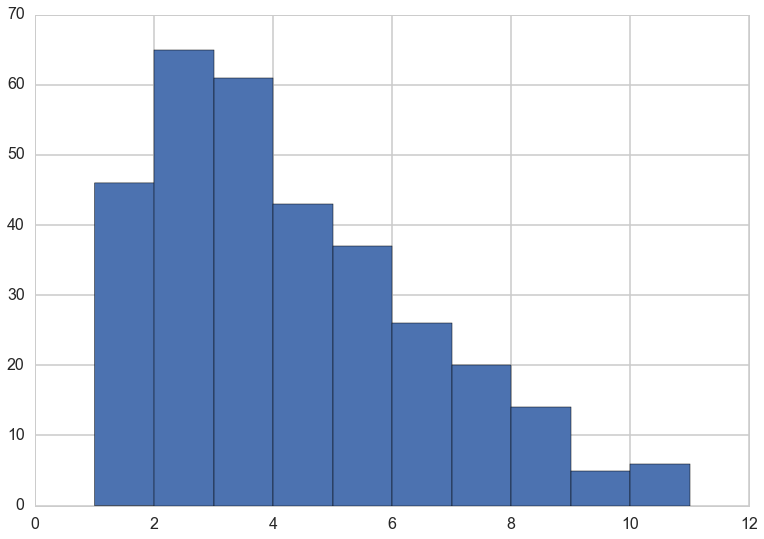

In [35]:
plt.hist(alldata[~np.isnan(alldata['yearstofirst'])]['yearstofirst'].values)

It looks like the vast majority of players who make the Pro Bowl make it within their first 5 years in the league. Let's check the actual proportion.

In [36]:
np.nanmean(alldata['yearstofirst'].values), np.nanmean(alldata[~np.isnan(alldata.yearstofirst)]['yearstofirst'].values < 6)

(3.8080495356037152, 0.7801857585139319)

So the average player makes his first Pro Bowl in his fourth year in the league, and around 80 percent of Pro Bowlers make the Pro Bowl in their first 5 years. This is evidence that the issue of right-censorship, while present, can be mitigated so long as we avoid training and testing on data within the last 5 years. If we have enough data, we might consider going back 6 years. Let's compare those two options.

In [79]:
print len(alldata[alldata.year <= 2009]), len(alldata[alldata.year <= 2008])

3095 2810


So discarding 2009 would reduce our sample size by about 300 observations. Let's check the proportion of players who make the Pro Bowl past their fifth year in the league and compare to the sixth.

In [82]:
print np.nanmean(alldata[~np.isnan(alldata.yearstofirst)]['yearstofirst'].values <= 6)

0.860681114551


We see that about 80 percent of players make their first Pro Bowl in their first 5 years in the league, while 86 percent make it within their first 6. To me, that's a large enough improvement to leave out an extra year. So we will use data from 1999 to 2008 in our analysis. Let's save this as `ungrouped`.

In [90]:
ungrouped = alldata[alldata.year <= 2008]
ungrouped.head()

2810


,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,...,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i,highpick_i
2136,2008,Husain Abdullah,Husain,Abdullah,FS,73,204,4.63,NaN,NaN,...,16,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2137,2008,Jamar Adams,Jamar,Adams,SS,74,212,4.59,4.49,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2138,2008,Xavier Adibi,Xavier,Adibi,OLB,74,232,4.69,4.47,NaN,...,NaN,4,Virginia Tech,19,118,0,NaN,NaN,0,0
2139,2008,Erik Ainge,Erik,Ainge,QB,78,225,4.98,4.60,NaN,...,NaN,5,Tennessee,27,162,0,NaN,NaN,0,0
2140,2008,Branden Albert,Branden,Albert,OG,78,309,5.17,4.78,NaN,...,23,1,Virginia,15,15,1,2013,6,1,1


Let's take a peek to see if there are any variables with too many missing values to use for analysis.

In [99]:
ungrouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2810 entries, 2136 to 4946
Data columns (total 22 columns):
year                 2810 non-null int64
name                 2810 non-null object
firstname            2810 non-null object
lastname             2810 non-null object
position             2810 non-null object
heightinchestotal    2810 non-null float64
weight               2810 non-null int64
fortyyd              2807 non-null float64
twentyss             2165 non-null float64
threecone            74 non-null float64
vertical             2510 non-null float64
broad                2426 non-null float64
bench                1986 non-null float64
round                1841 non-null float64
college              1841 non-null object
pickround            1841 non-null float64
picktotal            1841 non-null float64
probowls             2810 non-null float64
firstprobowl         229 non-null float64
yearstofirst         229 non-null float64
probowl_i            2810 non-null int64
hi

It looks like the three cone drill only has 74 observed values for almost 3000 observations. That's not particularly useful; let's discard it.

In [ ]:
ungrouped.drop('threecone', axis = 1, inplace = True)

Let's once again save this to a csv and write code we can run to load it later.

In [ ]:
ungrouped.to_csv("ungrouped.csv")
#ungrouped = pd.read_csv("ungrouped.csv")

###Grouped data

We also want to analyze our data by different position groups as specified before. We will now separate our ungrouped data into three different grouped files: `linedat`, `backsdat`, and `hybdat`.

In [92]:
linedat = ungrouped[ungrouped.position.isin(line)]
backsdat = ungrouped[ungrouped.position.isin(backs)]
hybdat = ungrouped[ungrouped.position.isin(hyb)]
linedat.head()

,year,name,firstname,lastname,position,heightinchestotal,weight,fortyyd,twentyss,threecone,...,bench,round,college,pickround,picktotal,probowls,firstprobowl,yearstofirst,probowl_i,highpick_i
2140,2008,Branden Albert,Branden,Albert,OG,78,309,5.17,4.78,NaN,...,23,1,Virginia,15,15,1,2013,6,1,1
2145,2008,Kentwan Balmer,Kentwan,Balmer,DT,77,308,5.29,4.82,NaN,...,33,1,North Carolina,29,29,0,NaN,NaN,0,0
2149,2008,Demetrius Bell,Demetrius,Bell,OT,77,303,5.25,4.65,NaN,...,9,7,Northwestern State,12,219,0,NaN,NaN,0,0
2156,2008,James Blair,James,Blair,OG,75,323,5.28,5.33,NaN,...,28,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2168,2008,Duane Brown,Duane,Brown,OT,76,315,5.07,4.52,NaN,...,24,1,Virginia Tech,26,26,3,2012,5,1,0


Let's see how many observations are in each group

In [93]:
print len(linedat), len(backsdat), len(hybdat)

962 1086 582


Our hybrid group is a lot smaller than the backs and line groups, but it's still large enough that we should be able to find a signal if it exists. Let's save these files into csvs.

In [ ]:
linedat.to_csv("linedat.csv")
backsdat.to_csv("backsdat.csv")
hybdat.to_csv("hybdat.csv")

Then we can run the following code to reload them.

In [ ]:
linedat = pd.read_csv("linedat.csv")
backsdat = pd.read_csv("backsdat.csv")
hybdat = pd.read_csv("hybdat.csv")

###Missing Data

For the grouped case, we will want to handle missing data values. Let's look at the missingness in each group and see what we have to deal with.